<a href="https://colab.research.google.com/github/as791/Adversarial-Example-Attack-and-Defense/blob/master/Adversarial_Example_(Attack_and_defense).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torchvision import transforms,datasets
from torch.autograd import Variable
import copy
from torch.autograd.gradcheck import zero_gradients
from scipy import optimize 

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.CIFAR10(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])
test_set = datasets.CIFAR10(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 313 Validation data: 79 Test data:  10000


In [5]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


##Attack

In [7]:
# NN Class model
class Net(nn.Module):
    def __init__(self):
      super().__init__() # To inherit all methods from parent class

      self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1) # args = (input_channels, output_channels, kernel_size, stride_length)
      self.conv2 = nn.Conv2d(64, 64, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1)
      self.conv4 = nn.Conv2d(128, 128, 3, 1, padding=1)

      # Calculations: 
      # No. of neurons in FC1 is (Number of channels)*(size of each channel after max pooling in conv3)
      # 32x32 -> conv1 -> 32x32 (after padding) -> conv2 -> 32x32 (after padding) -> max_pool1 -> 16x16 -> conv3 -> 16x16 (after padding) -> conv4 -> 16x16 (after padding) -> max_pool2 -> 8x8
      # size of each channel after max pooling in conv3 = 8*8
      # Number of channels = 128
      # No. of neurons in FC1 = 128*(8*8)

      self.fc1 = nn.Linear(8*8*128, 256)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(256, 256)
      self.dropout2 = nn.Dropout(0.5)
      self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
      # Defining architecture of NN
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 8*8*128) # Flattens to 1x8*8*128 row vector
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = F.relu(self.fc2(x))
      x = self.dropout2(x)
      x = self.fc3(x)
      x = F.log_softmax(x, dim=1)

      return x

In [8]:
model = Net().to(device)

In [9]:
#optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, dampening =0.5,)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

criterion = nn.NLLLoss()
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [10]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    #scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [11]:
def fit_and_save(model,devide,train_loader,val_loader,epochs,retrain):
    file_path = "./model/Exp1_CIFAR10.pth"
    if(retrain == True or not(os.path.exists(file_path))):
        loss,val_loss=fit(model,device,train_loader,val_loader,epochs)
        torch.save(model.state_dict(), file_path)
        np.save('./model/Exp1_CIFAR10_loss_array.npy', loss)
        np.save('./model/Exp1_CIFAR10_val_loss_array.npy', val_loss)
    else:
        model.load_state_dict(torch.load(file_path))
        loss = np.load('./model/Exp1_CIFAR10_loss_array.npy')
        val_loss = np.load('./model/Exp1_CIFAR10_val_loss_array.npy')
    return loss,val_loss

In [12]:
loss,val_loss=fit_and_save(model,device,train_loader,val_loader,50, False)

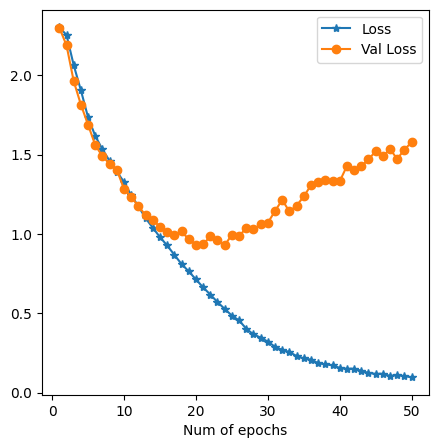

In [13]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,51), loss, "*-",label="Loss")
plt.plot(np.arange(1,51), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [14]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [15]:
def deepfool_attack(image, net, num_classes=10, overshoot = 0.02, max_iter=10):

    """
       :param image: Image of size HxWx3
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
    is_cuda = torch.cuda.is_available()

    if is_cuda:
        #print("Using GPU")
        image = image.cuda()
        net = net.cuda()
    else:
        print("Using CPU")


    f_image = net.forward(Variable(image, requires_grad=True)).data.cpu().numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.cpu().detach().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image, requires_grad=True)
    fs = net.forward(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            zero_gradients(x)

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        if is_cuda:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).cuda()
        else:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = Variable(pert_image, requires_grad=True)
        fs = net.forward(x)
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return pert_image

In [16]:
def flow_st(images,flows):
  images_shape = images.size()
  flows_shape = flows.size()
  batch_size = images_shape[0]
  H = images_shape[2]
  W = images_shape[3]
  basegrid = torch.stack(torch.meshgrid(torch.arange(0,H), torch.arange(0,W))) #(2,H,W)
  sampling_grid = basegrid.unsqueeze(0).type(torch.float32).cuda() + flows.cuda()
  sampling_grid_x = torch.clamp(sampling_grid[:,1],0.0,W-1.0).type(torch.float32)
  sampling_grid_y = torch.clamp(sampling_grid[:,0],0.0,H-1.0).type(torch.float32)

  x0 = torch.floor(sampling_grid_x).type(torch.int64)
  x1 = x0 + 1
  y0 = torch.floor(sampling_grid_y).type(torch.int64)
  y1 = y0 + 1

  x0 = torch.clamp(x0, 0, W - 2)
  x1 = torch.clamp(x1, 0, W - 1)
  y0 = torch.clamp(y0, 0, H - 2)
  y1 = torch.clamp(y1, 0, H - 1)
  
  Ia = images[:,:,y0[0,:,:], x0[0,:,:]]
  Ib = images[:,:,y1[0,:,:], x0[0,:,:]]
  Ic = images[:,:,y0[0,:,:], x1[0,:,:]]
  Id = images[:,:,y1[0,:,:], x1[0,:,:]]

  x0 = x0.type(torch.float32)
  x1 = x1.type(torch.float32)
  y0 = y0.type(torch.float32)
  y1 = y1.type(torch.float32)
  
  wa = (x1 - sampling_grid_x) * (y1 - sampling_grid_y)
  wb = (x1 - sampling_grid_x) * (sampling_grid_y - y0)
  wc = (sampling_grid_x - x0) * (y1 - sampling_grid_y)
  wd = (sampling_grid_x - x0) * (sampling_grid_y - y0)
  
  perturbed_image = wa.unsqueeze(0)*Ia+wb.unsqueeze(0)*Ib+wc.unsqueeze(0)*Ic+wd.unsqueeze(0)*Id

  return perturbed_image.type(torch.float32).cuda()

def flow_loss(flows,padding_mode='constant', epsilon=1e-8):
  paddings = (1,1,1,1)
  padded_flows = F.pad(flows,paddings,mode=padding_mode,value=0)
  shifted_flows = [
    padded_flows[:, :, 2:, 2:],  # bottom right (+1,+1)
    padded_flows[:, :, 2:, :-2],  # bottom left (+1,-1)
    padded_flows[:, :, :-2, 2:],  # top right (-1,+1)
    padded_flows[:, :, :-2, :-2]  # top left (-1,-1)
  ]
  #||\Delta u^{(p)} - \Delta u^{(q)}||_2^2 + # ||\Delta v^{(p)} - \Delta v^{(q)}||_2^2 
  loss=0
  for shifted_flow in shifted_flows:
    loss += torch.sum(torch.square(flows[:, 1] - shifted_flow[:, 1]) + torch.square(flows[:, 0] - shifted_flow[:, 0]) + epsilon).cuda()
  return loss.type(torch.float32)

def adv_loss(logits,targets,confidence=0.0):
  confidence=torch.tensor(confidence).cuda()
  real = torch.sum(logits*targets,-1)
  other = torch.max((1-targets)*logits-(targets*10000),-1)[0]
  return torch.max(other-real,confidence)[0].type(torch.float32)

def func(flows,input,target,model,const=0.05):
  input = torch.from_numpy(input).cuda()
  target = torch.from_numpy(target).cuda()
  flows = torch.from_numpy(flows).view((1,2,)+input.size()[2:]).cuda()
  flows.requires_grad=True
  pert_out = flow_st(input,flows)
  output = model(pert_out)
  L_flow = flow_loss(flows)
  L_adv = adv_loss(output,target)
  L_final = L_adv+const*L_flow
  model.zero_grad()
  L_final.backward()
  gradient = flows.grad.data.view(-1).detach().cpu().numpy()
  return L_final.item(),gradient

def spatial_attack(input,model,target):
  init_flows = np.zeros((1,2,)+input.size()[2:]).reshape(-1)
  results = optimize.fmin_l_bfgs_b(func,init_flows,args=(input.cpu().detach().numpy(),target.cpu().detach().numpy(),model))
  if b'CONVERGENCE' in results[2]['task']:
    flows = torch.from_numpy(results[0]).view((1,2,)+input.size()[2:])
    pert_out = flow_st(input,flows)
  else:
    return None
  return pert_out

In [17]:
def test_model(model,device,test_loader):
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() == target.item():
            correct += 1
        else:
            adv_ex = data.squeeze().detach().cpu().numpy()
            adv_examples.append((target.item(), init_pred.item(), adv_ex))
            
    final_acc = correct/float(len(test_loader))
    print("Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))
    
    return adv_examples
    
examples = test_model(model, device,test_loader)

Test Accuracy = 7139 / 10000 = 0.7139


In [18]:
from torch.utils.data import Dataset

class AugmentedDataset(Dataset):
    def __init__(self, X, y):
        # convert into PyTorch tensors and remember them
        self.X = X
        self.y = y
 
    def __len__(self):
        # this should return the size of the dataset
        return len(self.X)
 
    def __getitem__(self, idx):
        # this should return one sample from the dataset
        features = self.X[idx]
        target = self.y[idx]
        return features, target

In [19]:
def CreateTestDataset(model,device,loader,hyperparameter,attack):
  correct = 0
  X = []
  y = []
  i = 0
  for data, target in test_loader:
      if(i % 250 == 0):
        print(i/len(test_loader))
      i += 1
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,hyperparameter,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,hyperparameter,data_grad)
      elif attack == "deepfool":
        perturbed_data = deepfool_attack(data, model)
      elif attack == "spatial":
        random_target = hyperparameter
        attack_target = torch.from_numpy(np.expand_dims(np.eye(10, dtype=np.float32)[random_target],0)).cuda()
        perturbed_data = spatial_attack(data, model,attack_target)
    
      X.append(perturbed_data[0])
      y.append(target.item())

  return AugmentedDataset(X,y)

In [20]:
def CreateSpatialTestDataset(model,device,loader):
  correct = 0
  X = []
  y = []
  i = 0
  for data, target in test_loader:
    for attack_target in range(0, 10):
          if(i % 250 == 0):
            print(i/len(test_loader))
          i += 1
          data, target = data.to(device), target.to(device)
          data.requires_grad = True
          output = model(data)
          loss = F.nll_loss(output, target)
          model.zero_grad()
          loss.backward()
          data_grad = data.grad.data
          if attack_target != target.item():
              attack_target = torch.from_numpy(np.expand_dims(np.eye(10, dtype=np.float32)[attack_target],0)).cuda()
              perturbed_data = spatial_attack(data, model, attack_target)

              X.append(perturbed_data[0])
              y.append(target.item())

  return AugmentedDataset(X,y)

In [21]:
#fgsm_007_test = CreateTestDataset(model, device, test_loader, 0.007, "fgsm")
#print("fgsm 0.007 created")
#fgsm_01_test = CreateTestDataset(model, device, test_loader, 0.01, "fgsm")
#print("fgsm 0.01 created")
#fgsm_02_test = CreateTestDataset(model, device, test_loader, 0.02, "fgsm")
#print("fgsm 0.02 created")
#fgsm_03_test = CreateTestDataset(model, device, test_loader, 0.03, "fgsm")
#print("fgsm 0.03 created")
#fgsm_05_test = CreateTestDataset(model, device, test_loader, 0.05, "fgsm")
#print("fgsm 0.05 created")
#fgsm_1_test = CreateTestDataset(model, device, test_loader, 0.1, "fgsm")
#print("fgsm 0.1 created")
#fgsm_2_test = CreateTestDataset(model, device, test_loader, 0.2, "fgsm")
#print("fgsm 0.2 created")
#fgsm_3_test = CreateTestDataset(model, device, test_loader, 0.3, "fgsm")
#print("fgsm 0.3 created")


#mifgsm_007_test = CreateTestDataset(model, device, test_loader, 0.007, "mifgsm")
#print("mifgsm 0.007 created")
#mifgsm_01_test = CreateTestDataset(model, device, test_loader, 0.01, "mifgsm")
#print("mifgsm 0.01 created")
#mifgsm_02_test = CreateTestDataset(model, device, test_loader, 0.02, "mifgsm")
#print("mifgsm 0.02 created")
#mifgsm_03_test = CreateTestDataset(model, device, test_loader, 0.03, "mifgsm")
#print("mifgsm 0.03 created")
#mifgsm_05_test = CreateTestDataset(model, device, test_loader, 0.05, "mifgsm")
#print("mifgsm 0.05 created")
#mifgsm_1_test = CreateTestDataset(model, device, test_loader, 0.1, "mifgsm")
#print("mifgsm 0.1 created")
#mifgsm_2_test = CreateTestDataset(model, device, test_loader, 0.2, "mifgsm")
#print("mifgsm 0.2 created")
#mifgsm_3_test = CreateTestDataset(model, device, test_loader, 0.3, "mifgsm")
#print("mifgsm 0.3 created")

#deepfool_test = CreateTestDataset(model, device, test_loader, 0, "deepfool")
#print("deepfool created")

#spatial_test = CreateSpatialTestDataset(model, device, test_loader)
#print("spatial created")

#spatial_0_test = CreateTestDataset(model, device, test_loader, 0, "spatial")
#print("spatial created")
#spatial_1_test = CreateTestDataset(model, device, test_loader, 1, "spatial")
#print("spatial created")
#spatial_2_test = CreateTestDataset(model, device, test_loader, 2, "spatial")
#print("spatial created")
#spatial_3_test = CreateTestDataset(model, device, test_loader, 3, "spatial")
#print("spatial created")
#spatial_4_test = CreateTestDataset(model, device, test_loader, 4, "spatial")
#print("spatial created")
#spatial_5_test = CreateTestDataset(model, device, test_loader, 5, "spatial")
#print("spatial created")
#spatial_6_test = CreateTestDataset(model, device, test_loader, 6, "spatial")
#print("spatial created")
#spatial_7_test = CreateTestDataset(model, device, test_loader, 7, "spatial")
#print("spatial created")
spatial_8_test = CreateTestDataset(model, device, test_loader, 8, "spatial")
print("spatial created")
spatial_9_test = CreateTestDataset(model, device, test_loader, 9, "spatial")
print("spatial created")


0.0
0.025
0.05
0.075
0.1
0.125
0.15
0.175
0.2
0.225
0.25
0.275
0.3
0.325
0.35
0.375
0.4
0.425
0.45
0.475
0.5
0.525
0.55
0.575
0.6
0.625
0.65
0.675
0.7
0.725
0.75
0.775
0.8
0.825
0.85
0.875
0.9
0.925
0.95
0.975
spatial created
0.0
0.025
0.05
0.075
0.1
0.125
0.15
0.175
0.2
0.225
0.25
0.275
0.3
0.325
0.35
0.375
0.4
0.425
0.45
0.475
0.5
0.525
0.55
0.575
0.6
0.625
0.65
0.675
0.7
0.725
0.75
0.775
0.8
0.825
0.85
0.875
0.9
0.925
0.95
0.975
spatial created


In [22]:
#torch.save(fgsm_007_test,'./custom_datasets/CIFAR10_fgsm_007_test.pth')
#torch.save(fgsm_01_test,'./custom_datasets/CIFAR10_fgsm_01_test.pth')
#torch.save(fgsm_02_test,'./custom_datasets/CIFAR10_fgsm_02_test.pth')
#torch.save(fgsm_03_test,'./custom_datasets/CIFAR10_fgsm_03_test.pth')
#torch.save(fgsm_05_test,'./custom_datasets/CIFAR10_fgsm_05_test.pth')
#torch.save(fgsm_1_test,'./custom_datasets/CIFAR10_fgsm_1_test.pth')
#torch.save(fgsm_2_test,'./custom_datasets/CIFAR10_fgsm_2_test.pth')
#torch.save(fgsm_3_test,'./custom_datasets/CIFAR10_fgsm_3_test.pth')

#torch.save(mifgsm_007_test,'./custom_datasets/CIFAR10_mifgsm_007_test.pth')
#torch.save(mifgsm_01_test,'./custom_datasets/CIFAR10_mifgsm_01_test.pth')
#torch.save(mifgsm_02_test,'./custom_datasets/CIFAR10_mifgsm_02_test.pth')
#torch.save(mifgsm_03_test,'./custom_datasets/CIFAR10_mifgsm_03_test.pth')
#torch.save(mifgsm_05_test,'./custom_datasets/CIFAR10_mifgsm_05_test.pth')
#torch.save(mifgsm_1_test,'./custom_datasets/CIFAR10_mifgsm_1_test.pth')
#torch.save(mifgsm_2_test,'./custom_datasets/CIFAR10_mifgsm_2_test.pth')
#torch.save(mifgsm_3_test,'./custom_datasets/CIFAR10_mifgsm_3_test.pth')

#torch.save(deepfool_test,'./custom_datasets/CIFAR10_deepfool_test.pth')

#torch.save(spatial_test,'./custom_datasets/CIFAR10_spatial_test.pth')

#torch.save(spatial_0_test,'./custom_datasets/CIFAR10_spatial_0_test.pth')
#torch.save(spatial_1_test,'./custom_datasets/CIFAR10_spatial_1_test.pth')
#torch.save(spatial_2_test,'./custom_datasets/CIFAR10_spatial_2_test.pth')
#torch.save(spatial_3_test,'./custom_datasets/CIFAR10_spatial_3_test.pth')
#torch.save(spatial_4_test,'./custom_datasets/CIFAR10_spatial_4_test.pth')
#torch.save(spatial_5_test,'./custom_datasets/CIFAR10_spatial_5_test.pth')
#torch.save(spatial_6_test,'./custom_datasets/CIFAR10_spatial_6_test.pth')
#torch.save(spatial_7_test,'./custom_datasets/CIFAR10_spatial_7_test.pth')
torch.save(spatial_8_test,'./custom_datasets/CIFAR10_spatial_8_test.pth')
torch.save(spatial_9_test,'./custom_datasets/CIFAR10_spatial_9_test.pth')

In [23]:
#fgsm_007_test = torch.load('./custom_datasets/CIFAR10_fgsm_007_test.pth')
#print(fgsm_007_test.X[0])
#fgsm_01_test = torch.load('./custom_datasets/CIFAR10_fgsm_01_test.pth')
#print(fgsm_01_test.X[0])
#fgsm_02_test = torch.load('./custom_datasets/CIFAR10_fgsm_02_test.pth')
#print(fgsm_02_test.X[0])
#fgsm_03_test = torch.load('./custom_datasets/CIFAR10_fgsm_03_test.pth')
#print(fgsm_03_test.X[0])
#fgsm_05_test = torch.load('./custom_datasets/CIFAR10_fgsm_05_test.pth')
#print(fgsm_05_test.X[0])
#fgsm_1_test = torch.load('./custom_datasets/CIFAR10_fgsm_1_test.pth')
#print(fgsm_1_test.X[0])
#fgsm_2_test = torch.load('./custom_datasets/CIFAR10_fgsm_2_test.pth')
#print(fgsm_2_test.X[0])
#fgsm_3_test = torch.load('./custom_datasets/CIFAR10_fgsm_3_test.pth')
#print(fgsm_3_test.X[0])

#mifgsm_007_test = torch.load('./custom_datasets/CIFAR10_mifgsm_007_test.pth')
#print(mifgsm_007_test.X[0])
#mifgsm_01_test = torch.load('./custom_datasets/CIFAR10_mifgsm_01_test.pth')
#print(mifgsm_01_test.X[0])
#mifgsm_02_test = torch.load('./custom_datasets/CIFAR10_mifgsm_02_test.pth')
#print(mifgsm_02_test.X[0])
#mifgsm_03_test = torch.load('./custom_datasets/CIFAR10_mifgsm_03_test.pth')
#print(mifgsm_03_test.X[0])
#mifgsm_05_test = torch.load('./custom_datasets/CIFAR10_mifgsm_05_test.pth')
#print(mifgsm_05_test.X[0])
#mifgsm_1_test = torch.load('./custom_datasets/CIFAR10_mifgsm_1_test.pth')
#print(mifgsm_1_test.X[0])
#mifgsm_2_test = torch.load('./custom_datasets/CIFAR10_mifgsm_2_test.pth')
#print(mifgsm_2_test.X[0])
#mifgsm_3_test = torch.load('./custom_datasets/CIFAR10_mifgsm_3_test.pth')
#print(mifgsm_3_test.X[0])

#deepfool_test = torch.load('./custom_datasets/CIFAR10_deepfool_test.pth')
#print(deepfool_test.X[0])

#spatial_test = torch.load('./custom_datasets/CIFAR10_spatial_test.pth')
#print(spatial_test.X[0])

#spatial_0_test = torch.load('./custom_datasets/CIFAR10_spatial_0_test.pth')
#print(spatial_0_test.X[0])
#spatial_1_test = torch.load('./custom_datasets/CIFAR10_spatial_1_test.pth')
#print(spatial_1_test.X[0])
#spatial_2_test = torch.load('./custom_datasets/CIFAR10_spatial_2_test.pth')
#print(spatial_2_test.X[0])
#spatial_3_test = torch.load('./custom_datasets/CIFAR10_spatial_3_test.pth')
#print(spatial_3_test.X[0])
#spatial_4_test = torch.load('./custom_datasets/CIFAR10_spatial_4_test.pth')
#print(spatial_4_test.X[0])
#spatial_5_test = torch.load('./custom_datasets/CIFAR10_spatial_5_test.pth')
#print(spatial_5_test.X[0])
#spatial_6_test = torch.load('./custom_datasets/CIFAR10_spatial_6_test.pth')
#print(spatial_6_test.X[0])
#spatial_7_test = torch.load('./custom_datasets/CIFAR10_spatial_7_test.pth')
#print(spatial_7_test.X[0])
spatial_8_test = torch.load('./custom_datasets/CIFAR10_spatial_8_test.pth')
print(spatial_8_test.X[0])
spatial_9_test = torch.load('./custom_datasets/CIFAR10_spatial_9_test.pth')
print(spatial_9_test.X[0])


tensor([[[0.3765, 0.4549, 0.5255,  ..., 0.6510, 0.7137, 0.7176],
         [0.4235, 0.4941, 0.5569,  ..., 0.8078, 0.8980, 0.9098],
         [0.4667, 0.5255, 0.5765,  ..., 0.8353, 0.9451, 0.9216],
         ...,
         [0.2196, 0.2157, 0.3176,  ..., 0.0863, 0.0824, 0.0902],
         [0.2000, 0.2353, 0.3373,  ..., 0.0784, 0.0824, 0.0902],
         [0.2431, 0.2431, 0.2941,  ..., 0.0745, 0.0784, 0.0824]],

        [[0.4314, 0.5059, 0.5765,  ..., 0.5333, 0.5137, 0.5294],
         [0.4745, 0.5412, 0.6039,  ..., 0.2980, 0.1882, 0.2431],
         [0.5098, 0.5608, 0.6157,  ..., 0.2196, 0.1373, 0.1412],
         ...,
         [0.2549, 0.2549, 0.3490,  ..., 0.1137, 0.1216, 0.1333],
         [0.2353, 0.2706, 0.3725,  ..., 0.1137, 0.1176, 0.1255],
         [0.2824, 0.2784, 0.3294,  ..., 0.1059, 0.1137, 0.1176]],

        [[0.4706, 0.5647, 0.6235,  ..., 0.6392, 0.6039, 0.6588],
         [0.5176, 0.6000, 0.6510,  ..., 0.4510, 0.3373, 0.4000],
         [0.5529, 0.6275, 0.6667,  ..., 0.3804, 0.2863, 0.

In [24]:
#fgsm_007_test_loader = torch.utils.data.DataLoader(fgsm_007_test,batch_size=1,shuffle=True)
#test_model(model, device,fgsm_007_test_loader)
#fgsm_01_test_loader = torch.utils.data.DataLoader(fgsm_01_test,batch_size=1,shuffle=True)
#test_model(model, device,fgsm_01_test_loader)
#fgsm_02_test_loader = torch.utils.data.DataLoader(fgsm_02_test,batch_size=1,shuffle=True)
#test_model(model, device,fgsm_02_test_loader)
#fgsm_03_test_loader = torch.utils.data.DataLoader(fgsm_03_test,batch_size=1,shuffle=True)
#test_model(model, device,fgsm_03_test_loader)
#fgsm_05_test_loader = torch.utils.data.DataLoader(fgsm_05_test,batch_size=1,shuffle=True)
#test_model(model, device,fgsm_05_test_loader)
#fgsm_1_test_loader = torch.utils.data.DataLoader(fgsm_1_test,batch_size=1,shuffle=True)
#test_model(model, device,fgsm_1_test_loader)
#fgsm_2_test_loader = torch.utils.data.DataLoader(fgsm_2_test,batch_size=1,shuffle=True)
#test_model(model, device,fgsm_2_test_loader)
#fgsm_3_test_loader = torch.utils.data.DataLoader(fgsm_3_test,batch_size=1,shuffle=True)
#test_model(model, device,fgsm_3_test_loader)

#mifgsm_007_test_loader = torch.utils.data.DataLoader(mifgsm_007_test,batch_size=1,shuffle=True)
#test_model(model, device,mifgsm_007_test_loader)
#mifgsm_01_test_loader = torch.utils.data.DataLoader(mifgsm_01_test,batch_size=1,shuffle=True)
#test_model(model, device,mifgsm_01_test_loader)
#mifgsm_02_test_loader = torch.utils.data.DataLoader(mifgsm_02_test,batch_size=1,shuffle=True)
#test_model(model, device,mifgsm_02_test_loader)
#mifgsm_03_test_loader = torch.utils.data.DataLoader(mifgsm_03_test,batch_size=1,shuffle=True)
#test_model(model, device,mifgsm_03_test_loader)
#mifgsm_05_test_loader = torch.utils.data.DataLoader(mifgsm_05_test,batch_size=1,shuffle=True)
#test_model(model, device,mifgsm_05_test_loader)
#mifgsm_1_test_loader = torch.utils.data.DataLoader(mifgsm_1_test,batch_size=1,shuffle=True)
#test_model(model, device,mifgsm_1_test_loader)
#mifgsm_2_test_loader = torch.utils.data.DataLoader(mifgsm_2_test,batch_size=1,shuffle=True)
#test_model(model, device,mifgsm_2_test_loader)
#mifgsm_3_test_loader = torch.utils.data.DataLoader(mifgsm_3_test,batch_size=1,shuffle=True)
#test_model(model, device,mifgsm_3_test_loader)

#deepfool_test_loader = torch.utils.data.DataLoader(deepfool_test,batch_size=1,shuffle=True)
#test_model(model, device,deepfool_test_loader)

#spatial_test_loader = torch.utils.data.DataLoader(spatial_test,batch_size=1,shuffle=True)
#test_model(model, device,spatial_test_loader)

#spatial_0_test_loader = torch.utils.data.DataLoader(spatial_0_test,batch_size=1,shuffle=True)
#test_model(model, device,spatial_0_test_loader)
#spatial_1_test_loader = torch.utils.data.DataLoader(spatial_1_test,batch_size=1,shuffle=True)
#test_model(model, device,spatial_1_test_loader)
#spatial_2_test_loader = torch.utils.data.DataLoader(spatial_2_test,batch_size=1,shuffle=True)
#test_model(model, device,spatial_2_test_loader)
#spatial_3_test_loader = torch.utils.data.DataLoader(spatial_3_test,batch_size=1,shuffle=True)
#test_model(model, device,spatial_3_test_loader)
#spatial_4_test_loader = torch.utils.data.DataLoader(spatial_4_test,batch_size=1,shuffle=True)
#test_model(model, device,spatial_4_test_loader)
#spatial_5_test_loader = torch.utils.data.DataLoader(spatial_5_test,batch_size=1,shuffle=True)
#test_model(model, device,spatial_5_test_loader)
#spatial_6_test_loader = torch.utils.data.DataLoader(spatial_6_test,batch_size=1,shuffle=True)
#test_model(model, device,spatial_6_test_loader)
#spatial_7_test_loader = torch.utils.data.DataLoader(spatial_7_test,batch_size=1,shuffle=True)
#test_model(model, device,spatial_7_test_loader)
spatial_8_test_loader = torch.utils.data.DataLoader(spatial_8_test,batch_size=1,shuffle=True)
test_model(model, device,spatial_8_test_loader)
spatial_9_test_loader = torch.utils.data.DataLoader(spatial_9_test,batch_size=1,shuffle=True)
test_model(model, device,spatial_9_test_loader)

Test Accuracy = 6061 / 10000 = 0.6061
Test Accuracy = 6093 / 10000 = 0.6093


[(2,
  3,
  array([[[0.4862745 , 0.4862745 , 0.4862745 , ..., 0.46274108,
           0.45094824, 0.43137255],
          [0.5173381 , 0.51340246, 0.5174026 , ..., 0.47837904,
           0.47044688, 0.454919  ],
          [0.54497063, 0.54125965, 0.5453139 , ..., 0.4980143 ,
           0.4862599 , 0.4745216 ],
          ...,
          [0.7568521 , 0.7555434 , 0.77217853, ..., 0.6038223 ,
           0.5796519 , 0.54133415],
          [0.68152153, 0.6911981 , 0.6986955 , ..., 0.5542977 ,
           0.52270323, 0.5059294 ],
          [0.5137255 , 0.53723586, 0.57185006, ..., 0.40665376,
           0.37920037, 0.44705883]],
  
         [[0.5176471 , 0.5137271 , 0.5137255 , ..., 0.48627317,
           0.48234007, 0.4745098 ],
          [0.5487107 , 0.54472667, 0.54485565, ..., 0.50972986,
           0.5018532 , 0.4980597 ],
          [0.57634324, 0.57263225, 0.5766864 , ..., 0.54115   ,
           0.53331345, 0.52158046],
          ...,
          [0.7921569 , 0.7907369 , 0.80745417, ..., 0.63